In [1]:
import pandas as pd
from IPython.display import display

In [2]:
ufc_stats = pd.read_csv('data/stats/ufc_stats.csv')

In [3]:
ufc_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34436 entries, 0 to 34435
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     34436 non-null  int64  
 1   fighter                        34436 non-null  object 
 2   knockdowns                     34436 non-null  int64  
 3   significant_strikes_landed     34436 non-null  int64  
 4   significant_strikes_attempted  34436 non-null  int64  
 5   significant_strikes_rate       34436 non-null  float64
 6   total_strikes_landed           34436 non-null  int64  
 7   total_strikes_attempted        34436 non-null  int64  
 8   takedown_successful            34436 non-null  int64  
 9   takedown_attempted             34436 non-null  int64  
 10  takedown_rate                  34436 non-null  float64
 11  submission_attempt             34436 non-null  int64  
 12  reversals                      34436 non-null 

In [4]:
nb_fighters = len(ufc_stats['fighter'].unique())
print('Number of fighters : ', nb_fighters)


Number of fighters :  2448


In [5]:
def get_fights(fighter_name):
    all_fights = ufc_stats[ufc_stats['fighter'] == fighter_name]
    return all_fights

def clean_columns(data):
    cleaned_data = data.drop(columns=['fighter', 'Unnamed: 0', 'event', 'location', 'attendance', 'time', 'scheduled_rounds', 'weight_class', 'round', 'last_round', 'id', 'result', 'winner', 'fight_date'])
    # remove columns named "fighter", "Unnamed: 0", "event", "fight_date", "location", "attendance"
    # Convert the "fight_date" column to a datetime data type
    #cleaned_data['fight_date'] = pd.to_datetime(cleaned_data['fight_date'])
    return cleaned_data

def get_last_fights(data):
    df = data.sort_values(by=['fight_date'], ascending=False)
    # Group the DataFrame by the unique fight ID
    grouped = df.groupby('id', sort=False)
    # Get the first nb_fights groups (corresponding to the first nb_fights fights)
    first_nb_fights = [group for _, group in grouped]
    # Concatenate the DataFrames for the first nb_fights fights
    result_df = pd.concat(first_nb_fights)
    # Reset the index of the result DataFrame if needed
    result_df.reset_index(drop=True, inplace=True)
    return result_df

def get_all_oponents(fighter_name):
    all_fights = get_fights(fighter_name)
    fights_ids = all_fights['id'].unique()
    filtered_fights = ufc_stats[(ufc_stats['id'].isin(fights_ids)) & (ufc_stats['fighter'] != fighter_name)]['fighter'].unique()
    return filtered_fights

def get_winner(fighter_name_1, fighter_name_2):
    all_fights = get_fights(fighter_name_1)
    fights_ids = all_fights['id'].unique()
    filtered_fights = ufc_stats[(ufc_stats['id'].isin(fights_ids)) & (ufc_stats['fighter'] != fighter_name_1) & (ufc_stats['fighter'] == fighter_name_2)]
    grouped = filtered_fights.groupby('id', sort=False)
    fights = [group.iloc[0] for _, group in grouped]
    fights = pd.DataFrame(fights)
    res = fights['winner'].value_counts()
    
    # return -1 if no fight found
    if len(res) == 0:
         return -1

    res = res.index[0]
    return 0 if res == 'L' else 1

def get_all_fighters_name():
    return ufc_stats['fighter'].unique()

def compute_extra_features(data: pd.DataFrame) -> pd.DataFrame:
    # compute nb fights
    nb_fights = len(data['id'].unique())
    extra_features = {
        'nb_fights': [nb_fights],
        'L': 0,
        'W': 0,
        'D': 0,
        'NC': 0   
    }
    #compute nb wins / loses
    grouped = data.groupby('id')
    fights = [group.iloc[0] for _, group in grouped]
    fights = pd.DataFrame(fights)
    wins_loses = fights['winner'].value_counts()
    extra_features.update(wins_loses)
    return pd.DataFrame(extra_features)

def get_fighter_data(fighter_name):
    fights = get_fights(fighter_name)
    extra_features = compute_extra_features(fights)
    fights = clean_columns(fights)
    #last_fights = get_last_fights(all_fights)
    #all_fights = all_fights.drop(columns=['round', 'last_round', 'id', 'result', 'winner', 'fight_date'])
    fights = fights.median().to_frame().transpose()
    fights = pd.concat([extra_features, fights], axis=1)

    return fights

In [6]:
get_all_oponents('Conor McGregor')

array(['Dustin Poirier', 'Donald Cerrone', 'Khabib Nurmagomedov',
       'Eddie Alvarez', 'Nate Diaz', 'Jose Aldo', 'Chad Mendes',
       'Dennis Siver', 'Diego Brandao', 'Max Holloway', 'Marcus Brimage'],
      dtype=object)

In [7]:
fighter_data_1 = get_fighter_data('Conor McGregor')
fighter_data_2 = get_fighter_data('Dustin Poirier')
winner = get_winner('Conor McGregor', 'Dustin Poirier')
df = pd.concat([fighter_data_1, fighter_data_2])
display(df)
print("Winner ", winner)

,nb_fights,L,W,D,NC,knockdowns,significant_strikes_landed,significant_strikes_attempted,significant_strikes_rate,total_strikes_landed,...,body_landed,body_attempted,leg_landed,leg_attempted,distance_landed,distance_attempted,clinch_landed,clinch_attempted,ground_landed,ground_attempted
0,14,4,10,0,0,0.0,20.0,39.5,0.54,30.0,...,3.0,4.0,1.0,2.0,15.0,31.5,1.0,1.0,1.0,1.5
0,29,7,21,0,1,0.0,25.0,46.0,0.50,29.0,...,1.0,2.0,2.0,2.0,16.0,32.0,1.0,2.0,0.0,0.0


Winner  1


Number of fights by fighter

In [14]:
names = get_all_fighters_name()

data = []
for fighter_name in names:
    fights = get_fights(fighter_name)
    extra_features = compute_extra_features(fights)
    extra_features['fighter'] = fighter_name
    data.append(extra_features)

In [20]:
fighter_fights = pd.concat(data)
fighter_fights.sort_values('nb_fights', ascending=False, inplace=True)
display(fighter_fights)

,nb_fights,L,W,D,NC,fighter
0,42,16,25,0,1,Jim Miller
0,40,16,23,0,1,Andrei Arlovski
0,38,14,23,1,0,Donald Cerrone
0,35,17,18,0,0,Clay Guida
0,34,13,21,0,0,Rafael Dos Anjos
...,...,...,...,...,...,...
0,1,1,0,0,0,Stephen Bass
0,1,1,0,0,0,Chris Saunders
0,1,1,0,0,0,Chris Tickle
0,1,1,0,0,0,Wagner Campos


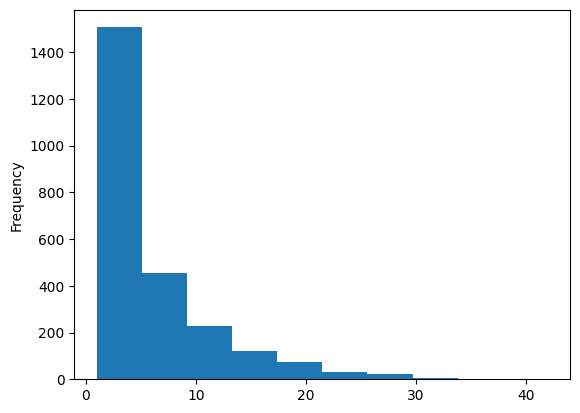

In [22]:
ax = fighter_fights['nb_fights'].plot.hist()

## Prepare data

In [63]:
fighter_data_1 = get_fighter_data('Conor McGregor')
columns = fighter_data_1.columns.to_list()
for index, col in enumerate(fighter_data_1.columns):
    new_col = col + '_1'
    columns.append(new_col)

columns.append('winner')

print(columns)

['nb_fights', 'L', 'W', 'D', 'NC', 'knockdowns', 'significant_strikes_landed', 'significant_strikes_attempted', 'significant_strikes_rate', 'total_strikes_landed', 'total_strikes_attempted', 'takedown_successful', 'takedown_attempted', 'takedown_rate', 'submission_attempt', 'reversals', 'head_landed', 'head_attempted', 'body_landed', 'body_attempted', 'leg_landed', 'leg_attempted', 'distance_landed', 'distance_attempted', 'clinch_landed', 'clinch_attempted', 'ground_landed', 'ground_attempted', 'nb_fights_1', 'L_1', 'W_1', 'D_1', 'NC_1', 'knockdowns_1', 'significant_strikes_landed_1', 'significant_strikes_attempted_1', 'significant_strikes_rate_1', 'total_strikes_landed_1', 'total_strikes_attempted_1', 'takedown_successful_1', 'takedown_attempted_1', 'takedown_rate_1', 'submission_attempt_1', 'reversals_1', 'head_landed_1', 'head_attempted_1', 'body_landed_1', 'body_attempted_1', 'leg_landed_1', 'leg_attempted_1', 'distance_landed_1', 'distance_attempted_1', 'clinch_landed_1', 'clinch_

In [64]:
from tqdm import tqdm

results = []
data = []

fighters_name = get_all_fighters_name()
for fighter in tqdm(fighters_name):
    all_oponents = get_all_oponents(fighter)
    fighter_data_1 = get_fighter_data(fighter)
    for oponent in all_oponents:
        fighter_data_2 = get_fighter_data(oponent)
        winner = get_winner(fighter, oponent)
        data.append(fighter_data_1.values.tolist()[0] + fighter_data_2.values.tolist()[0] + [winner])

df = pd.DataFrame(data=data, columns=columns)


  0%|          | 0/2448 [00:00<?, ?it/s]

100%|██████████| 2448/2448 [03:04<00:00, 13.26it/s]


In [65]:
df.to_csv('fighter_stats.csv', index=False)